Use Neural Network to classify the images from **CIFAR-10** dataset

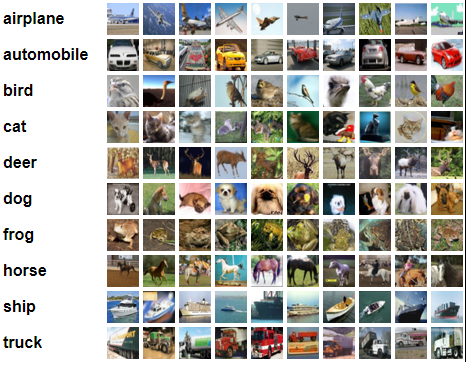

#Select **T4 GPU** (free) in Cobal Notebook settings to speed up the training

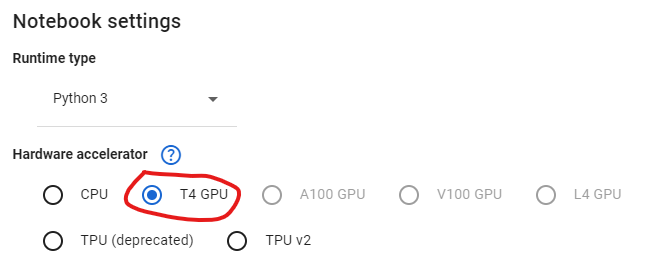

In [ ]:
#@title Execute this block to import TensorFlow deep learning library

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

# Predict individual image
def predictOneImage(x_test, y_test, ans, p_index):
  first_image = x_test[p_index]
  plt.imshow(first_image)
  plt.show()

  count = 0
  for a in ans[p_index]:
      print(labels[count], "=", round(a*100, 2))
      count = count + 1

  print("------------------")
  print("True Label:", labels[y_test[p_index][0]])

In [ ]:
#@title Downloand the CIFAR-10 labelled data, split them into train and test sets

# https://www.cs.toronto.edu/~kriz/cifar.html
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

labels = {
    0: "plane",
    1: "car  ",
    2: "bird ",
    3: "cat  ",
    4: "deer ",
    5: "dog  ",
    6: "frog ",
    7: "horse",
    8: "ship ",
    9: "truck",
}

train_size, test_size = x_train.shape[0], x_test.shape[0]
height, width, depth = x_train.shape[1], x_train.shape[2], x_train.shape[3]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
#@title Visualize the training data. Pick one sample from the training data set

training_sample = 0 #@param {type:"integer"}

print(x_train[training_sample])
first_image = x_train[training_sample]
plt.imshow(first_image)
plt.show()

print("Label:", labels[y_train[training_sample][0]])

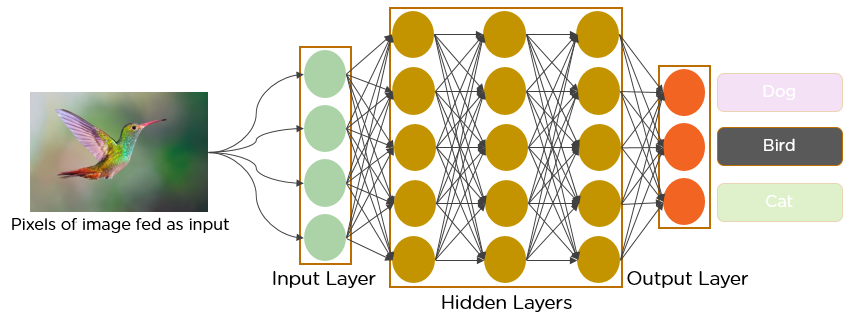

In [ ]:
#@title Convert the image pixels to neural network input vector format

# For Dense Neural Network
# reshape the 32x32x3 pixels to a 3072 array
# and normalize the number by 255

dim = height * width * depth
x_trainp = x_train.reshape(train_size, dim)
x_testp = x_test.reshape(test_size, dim)

normalize = 255
x_trainp = x_trainp.astype('float32') / normalize
x_testp = x_testp.astype('float32') / normalize

print(x_trainp.shape[0], 'train samples')
print(x_testp.shape[0], 'test samples')

In [ ]:
# Look at one example of reshaped (flatten) and normalized training data
print(*x_trainp[0])

In [ ]:
#@title Convert the Output (image label) to neural network vector format (one-hot encoding)

num_classes = 10

y_trainp = keras.utils.to_categorical(y_train, num_classes)
y_testp = keras.utils.to_categorical(y_test, num_classes)


print("one-hot encoding: ", labels)

print(labels[y_train[0][0]], ": ", y_trainp[0])
print(labels[y_train[1][0]], ": ", y_trainp[1])


In [ ]:
# Dense Neural Network with multiple hidden layers
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(dim,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary()
# Param calculation in each layer = input * output + output bias
# Input images = 32 * 32 * 3 = 3072
# dense Params =  = 3072 * 64 + 64 = 196672
# dense_1 params = 64 * 32 + 32 = 30 = 2080
# dense_2 params = 32 * 10 + 10 = 30 = 330

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#@title Train the Neural Network with the input number of epochs

epochs = 10 #@param {type:"integer"}

# stochastic gradient descent
batch_size = 128

# Set aside the first 10,000 samples as the validation set
val_size = 10000
x_valp = x_trainp[:val_size]
partial_x_trainp = x_trainp[val_size:]

y_valp = y_trainp[:val_size]
partial_y_trainp = y_trainp[val_size:]

history = model.fit(partial_x_trainp, partial_y_trainp,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_valp, y_valp))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(1, len(acc) + 1)

plt.plot(epoch, acc, 'r', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()


# Do the prediction on test set
score = model.evaluate(x_testp, y_testp, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ans = model.predict(x_testp)

In [ ]:
#@title Pick one sample from the testing data to verify the prediction

test_sample = 0 #@param {type:"integer"}

predictOneImage(x_test, y_test, ans, test_sample)


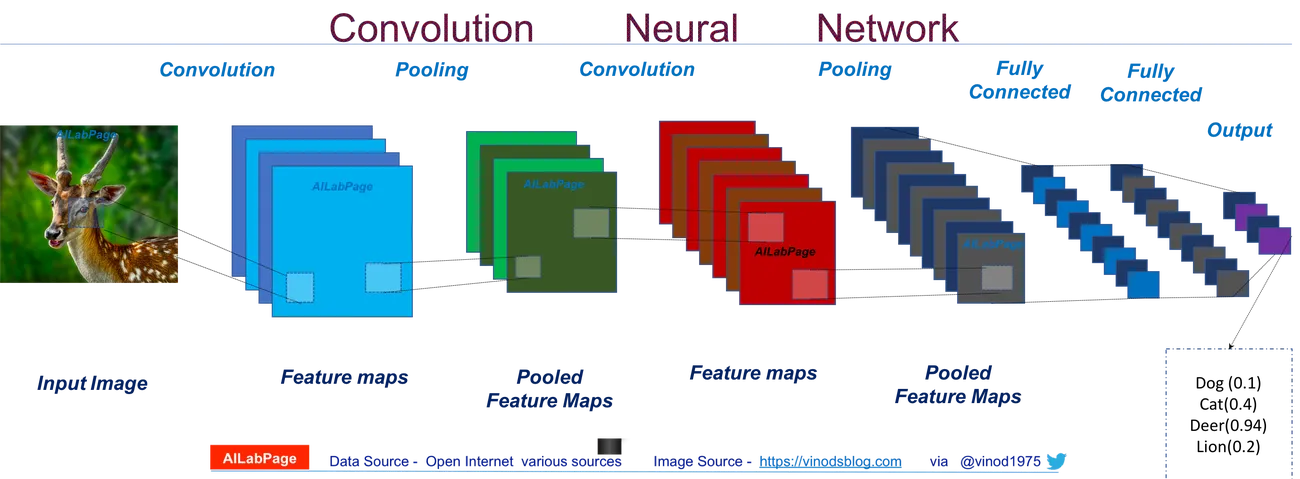

In [ ]:
#@title Convert the input pixels to CNN neural network input vector format

# Use CNN and reshape the 32x32x3 pixels
# and normalize the number by 255

x_trainCnn = x_train.reshape(train_size, height, width, depth)
x_testCnn = x_test.reshape(test_size, height, width, depth)

x_trainCnn = x_trainCnn.astype('float32') / normalize
x_testCnn = x_testCnn.astype('float32') / normalize

print(x_trainCnn.shape[0], 'train samples')
print(x_testCnn.shape[0], 'test samples')

In [ ]:
# Use CNN
cnn = Sequential()

# Filter = 32, Kernel_size = 3 * 3
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))

cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(10, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])


cnn.summary()
# Pooling Layer: There are no parameters you could learn in pooling layer. This layer is just used to reduce the image dimension size.
# Conv layer parameters:  (n * m * l + 1) * k,  where n * m is the kernel_size, l is input filter, k is the output filter
# conv2d = (3 * 3 * 3 + 1) * 32 = 896
# conv2d_1 = (3 * 3 * 32 + 1) * 64 = 18496
# conv2d_2 = (3 * 3 * 64 + 1) * 64 = 36928

plot_model(cnn, show_shapes=True, show_layer_names=True)

In [ ]:
#@title Train the Neural Network with the input number of epochs

epochs = 10 #@param {type:"integer"}

# Set aside the some samples as the validation set
x_valCnn = x_trainCnn[:val_size]
partial_x_trainCnn = x_trainCnn[val_size:]


history = cnn.fit(partial_x_trainCnn, partial_y_trainp,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_valCnn, y_valp))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(1, len(acc) + 1)

plt.plot(epoch, acc, 'r', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Do the prediction on test set
score = cnn.evaluate(x_testCnn, y_testp, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

cnnAns = cnn.predict(x_testCnn)

In [ ]:
#@title Pick one sample from the testing data to verify the prediction

test_sample = 0 #@param {type:"integer"}
predictOneImage(x_test, y_test, cnnAns, test_sample)

# Use pre-trained VGG Imagenet CNN layers
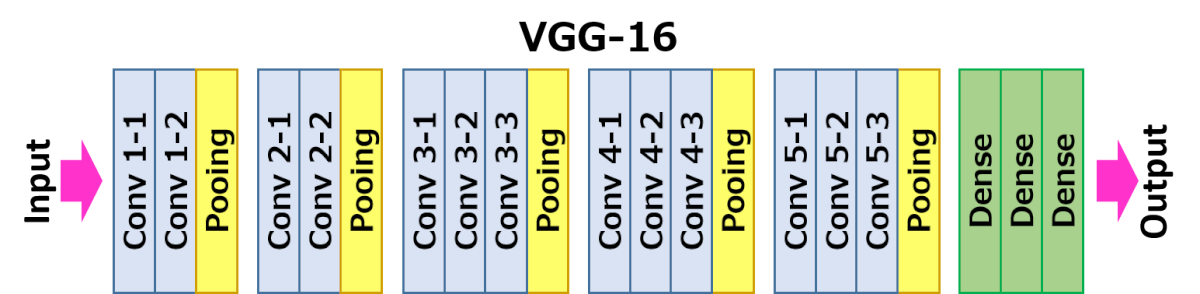

In [ ]:
#@title Load the pre-trained VGG Imagenet CNN layers

# include_top=False: doesn't include the densely connected classifier layers on top of the network
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, depth))
conv_base.trainable = True

# Fine-tune the last 3 convolutional layers (i.e. block5)
# Usually fine-tune the last few convolutional layers as it's more higher level (abstract) features to the problem
# while the first few layers are more generic and re-usable features
for layer in conv_base.layers:
  if layer.name[:6] != 'block5':
    layer.trainable = False

conv_base.summary()

plot_model(conv_base, show_shapes=True, show_layer_names=True)

In [ ]:
# Use CNN with pre-trained VGG layer
pModel = Sequential()

pModel.add(conv_base)
pModel.add(Flatten())
pModel.add(Dense(64, activation='relu'))
pModel.add(Dense(10, activation='softmax'))

pModel.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

pModel.summary()

plot_model(pModel, show_shapes=True, show_layer_names=True)

In [ ]:
#@title Train the Neural Network with the input number of epochs

epochs = 10 #@param {type:"integer"}

history = pModel.fit(partial_x_trainCnn, partial_y_trainp,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_valCnn, y_valp))

# Plot the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epoch = range(1, len(acc) + 1)

plt.plot(epoch, acc, 'r', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Do the prediction on test set
score = pModel.evaluate(x_testCnn, y_testp, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pAns = pModel.predict(x_testCnn)

In [ ]:
#@title Pick one sample from the testing data to verify the prediction

test_sample = 0 #@param {type:"integer"}

predictOneImage(x_test, y_test, pAns, test_sample)